In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

from progressbar import ProgressBar



import datetime
import calendar


%matplotlib inline

#custom functions
def NSC(y_pred,y_true):
    """
    Nash-Sutcliffe Coefficient
    """
    return 1 - sum((y_pred-y_true)**2)/sum((y_true-np.mean(y_true))**2)




In [22]:
#Load model training and testing data
trainPath = Path('Final/Train')
testPath = Path('Final/Validate')

#This loads all excel files in the fold into a python dictionary format
#Training data
slc_train = {i.stem[0:3] : pd.read_excel(i) for i in trainPath.glob('**/*.xlsx')}
#Testing data
slc_test = {i.stem[0:3] : pd.read_excel(i) for i in testPath.glob('**/*.xlsx')}

for i in slc_train:
    slc_train[i].index = slc_train[i]['Year']
    slc_test[i].index = slc_test[i]['Year']
    del slc_train[i]['Year']
    del slc_test[i]['Year']
    
#This is the final dataset to make predictions on
AllData = Path('Final/AllData')

slcallData = {i.stem[0:3] : pd.read_excel(i) for i in AllData.glob('**/*.xlsx')}

#rename the gpcd column
for i in slcallData:
    slcallData[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slcallData[i]=slcallData[i].set_index('Year')
snow=pd.read_excel('Final/SnowData/Alta_LCC_snow.xlsx')
snow=snow.set_index('Year')
    

'''
This is going to be CSD-WDM step 1, taking the train and validation data and processing it so that the model can be trained.
This will need to be put into a class struture/OOP.
'''
#split training and testing data into features and targets
slc_train_target=copy.deepcopy(slc_train)
slc_train_features=copy.deepcopy(slc_train)

slc_test_target=copy.deepcopy(slc_test)
slc_test_features=copy.deepcopy(slc_test)

target=['Target_gpcd']
for i in slc_train_target:
    slc_train_target[i]=slc_train_target[i]['Target_gpcd']
    #for now include testing years
    slc_test_target[i]=slc_test_target[i]['Target_gpcd']


    slc_train_features[i]= slc_train_features[i].drop(columns=target)
    #for now include testing years
    slc_test_features[i]= slc_test_features[i].drop(columns=target)
    
#Determine the indoor mean to subtract from outdoor
I_mean_train=(slc_train['Jan']['Target_gpcd']+
              slc_train['Feb']['Target_gpcd']+
              slc_train['Mar']['Target_gpcd']+
              slc_train['Nov']['Target_gpcd']+
             slc_train['Dec']['Target_gpcd'])/5
I_mean_test=(slc_test['Jan']['Target_gpcd']+
             slc_test['Feb']['Target_gpcd']+
             slc_test['Mar']['Target_gpcd']+
             slc_test['Nov']['Target_gpcd']+
             slc_test['Dec']['Target_gpcd'])/5
#This uses total demand for irrigation seasons

Cons_mean_test=(slc_test['Jan']['cons_goal']+
                slc_test['Feb']['cons_goal']+
                slc_test['Mar']['cons_goal']+
                slc_test['Nov']['cons_goal']+
                slc_test['Dec']['cons_goal'])/5

In [3]:
'''
We want to see the trends for the training data,# and will want to have them modeled into the future based
on consevation goals

From plots, There appears to be very little trends in training data. The last 10 years do show decreasing trends
likely due to conservation goals established in 2005


Thinking of a stepwise process:
1) identify any trends (training and testing): check, no trends in training. however in 2000, Utah established a 
   conservation goal. To reduce the gpcd water use by 25% by 2025. Evaluating water use from 2005-2017 shows a decline
   in water use.
2) Determine conservation goals (annual reduction /yr, slope), over 25yrs a 75 gpcd reduction is requested (3gpcd/yr), check
3) Separately model indoor and outdoor demands per year. check 
4) Training Outdoor demand (Apr-Oct) will be that month's total demand minus that years Jan-Mar mean indoor demand
5) Final model = modeled indoor demand - conservation reduction + Outdoor demand (if Apr-Oct).
'''

def Outdoor_Demand_Model(TrainDF, month, X_train_features, y_train_target, X_test_features,
                         y_test_target, snowfeatures, conservation, cor_threshold, colinearity_thresh,
                         cv_splits,model_type, scoring):
  

#subset these features out of main DF and put into cute heatmap plot
    
    DFcor = copy.deepcopy(TrainDF[month])
    
    #if snowfeatures is True:
     #   print('LCC Snowfeatures are being used')
    if snowfeatures is False:
        snow=['Nov_snow_in','Dec_snow_in', 'Jan_snow_in','Feb_snow_in', 
              'Mar_snow_in','Apr_snow_in', 'Total_snow_in', 'Snow_shortage']
        DFcor=DFcor.drop(columns=snow)

    
    cor=DFcor.copy()
    if conservation is False:
        del cor['cons_goal']
        cor = cor.corr()
        cor =cor.iloc[:,-1:]
    if conservation is True:
        cor = cor.corr()
        cor =cor.iloc[:,-2:]
        del cor['cons_goal']
        
    cor['Target_gpcd']=np.abs(cor['Target_gpcd'])
    cor=cor.sort_values(by=['Target_gpcd'], ascending=False)
    cor=cor.dropna()

#Selecting highly correlated features
    relevant_features = cor[cor['Target_gpcd']>cor_threshold]
    CorFeat = list(relevant_features.index)

    CorDF= DFcor[CorFeat]
    cor = np.abs(CorDF.corr())
    cor = cor.mask(np.tril(np.ones(cor.shape)).astype(np.bool))
    #remove colinearity
    cor = cor[cor.columns[cor.max() < colinearity_thresh]]
    CorFeat=cor.columns
    cor = cor.T
    cor = cor[CorFeat]
    
    #print('Remaining features are', CorFeat)

    
   #Set up training and testing data 
    X_train = X_train_features[month][CorFeat].copy()
#X_train = slc_train_features['Jul'][JulF]
    y_train = y_train_target[month].copy()

    X_test = X_test_features[month][CorFeat].copy()
#X_test = slc_test_features['Jul'][JulF]
    y_test = y_test_target[month].copy()

    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)

# step-2: specify range of hyperparameters to tune
    if len(CorFeat) > 1 :
        hyper_params = [{'n_features_to_select': list(range(1, len(CorFeat)))}]
        

# step-3: perform grid search
# 3.1 specify model, key to set intercept to false
        trainmodel = model_type
        trainmodel.fit(X_train, y_train)
        rfe = RFE(trainmodel)             

# 3.2 call GridSearchCV()
        model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= scoring, 
                        cv = folds, 
                        verbose = 0,
                        return_train_score=True)      

# fit the model
        model_cv.fit(X_train, y_train)

# create a KFold object with 5 splits 
        folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)
        scores = cross_val_score(trainmodel, X_train, y_train, scoring=scoring, cv=folds)
       # print('CV scores = ', scores) 

# cv results
        cv_results = pd.DataFrame(model_cv.cv_results_)

    
     #code to select features for final model, tell how many features
        N_feat=cv_results.loc[cv_results['mean_test_score'].idxmax()]
        N_feat=N_feat['param_n_features_to_select']
        #print('Number of features to select is ', N_feat)
    # intermediate model
        n_features_optimal = N_feat

        Int_model = model_type
        Int_model.fit(X_train, y_train)

        rfe = RFE(Int_model, n_features_to_select=n_features_optimal)             
        rfe = rfe.fit(X_train, y_train)

#make the final model with rfe features

# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features

        Features =list(zip(X_train.columns,rfe.support_,rfe.ranking_))
        FeaturesDF=pd.DataFrame(Features, columns=['Feature', 'Important', 'Score'])
        FeaturesDF = FeaturesDF[FeaturesDF.Score<=1]
        RFE_features = list(FeaturesDF['Feature'])
       # print('The final features are ', RFE_features)
        
        #select only RFE features for model training/validation
        X_train = X_train[RFE_features]
        X_test = X_test[RFE_features]

    
    #plot of selected features to make sure not colinear
        CorDF= X_train.copy()
        CorDF['Target_gpcd']=slc_train[month]['Target_gpcd']

        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
   
        
    else:
          
       #Set up training and testing data to have a random non-correlated feature then
        X_train = X_train_features[month]['HousingDensity'].copy()
        X_test = X_test_features[month]['HousingDensity'].copy()
        cv_results = 0
        cor = 0
        
        len1 = len(X_train)
        len2 = len(X_test)
        
        X_train = np.array(X_train).reshape(len1, 1)
        X_test = np.array(X_test).reshape(len2, 1)
        
        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
    # Get training data model performance to tune hyperparameters
    yt_pred = Final_model.predict(X_train)
    
    yt_pred = [0 if x < 0 else x for x in yt_pred]
    O_r2_train = sklearn.metrics.r2_score(y_train, yt_pred)
    O_rmse_train = sklearn.metrics.mean_squared_error(y_train, yt_pred, squared = False)
   
# predict X_test
    y_pred = Final_model.predict(X_test)
    
    y_pred = [0 if x < 0 else x for x in y_pred]
    O_r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    O_rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    
 

#plot the predictions
    PerfDF=pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])

#Add indoor demands
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if month in Indoor:
        PerfDF['y_test']=PerfDF['y_test']
        PerfDF['y_pred']=PerfDF['y_pred']
    else:
        PerfDF['y_test_tot']=PerfDF['y_test']+list(I_mean_test)
        PerfDF['y_pred_tot']=PerfDF['y_pred']+list(Cons_mean_test)

    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'], PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'], PerfDF['y_pred_tot'], 
                                               squared = False)

    #print('Total R2 is ', T_r2)
    #print('Total rmse is ', T_rmse)
  

    PerfDF['Year'] = list(slc_test['Jul'].index)
    PerfDF=PerfDF.set_index('Year')
   

    datetime_object = datetime.datetime.strptime(month, "%b")
    PerfDF['month'] = datetime_object.month
    PerfDF['Year']=PerfDF.index
   
    
    #set up dates so all months can be combined and sorted
    day=[]
    for index, row in PerfDF.iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    PerfDF['Day']=day
  
    PerfDF['Date'] = pd.to_datetime(PerfDF[['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    PerfDF=PerfDF.drop(columns=['Year', 'month', 'Day'])
    PerfDF=PerfDF.reset_index()
    
    params = [snowfeatures, conservation, cor_threshold, colinearity_thresh]
    EstParams = Final_model.get_params()
    
    return X_test, PerfDF, O_rmse_train, O_r2_train ,O_rmse_test, O_r2_test , params, cv_results, cor , Final_model.coef_

In [4]:
'''
Lets try this module to make a demand forecast first
'''

def Indoor_Demand_Model(df, month):
    #Make matching indoor demand model
    datetime_object = datetime.datetime.strptime(month, "%b")
    df[month]['month'] = datetime_object.month
    
    df[month]['Year']=df[month].index
    
     #set up dates so all months can be combined and sorted
    day=[]
    for index, row in df[month].iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    df[month]['Day']=day
    
  
    df[month]['Date'] = pd.to_datetime(df[month][['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    df[month]=df[month].drop(columns=['month', 'Day'])
    df[month]=df[month].reset_index(drop=True)
   
    
    colrem = slc_test[i].columns
    df[month]['y_pred'] =  df[month]['cons_goal']
    df[month]['y_test'] =  df[month]['Target_gpcd']
    df[month]['y_pred_tot'] =  df[month]['cons_goal']
    df[month]['y_test_tot'] =  df[month]['Target_gpcd']
       
    df[month] = df[month].set_index('Date')
    
    df[month] = df[month].drop(columns=colrem)
    
    return df

In [5]:
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral')
    ax.axis([xmin, xmax, ymin, ymax])


In [6]:
def model_plots(PerfDF, cv_results,cor, X_test_RFE, coef, scoring, month):
    
    plotmin = PerfDF[['y_pred', 'y_test']].min().min()
    plotmax = PerfDF[['y_pred', 'y_test']].max().max()
    
    plotmin_tot = PerfDF[['y_pred_tot', 'y_test_tot']].min().min()
    plotmax_tot = PerfDF[['y_pred_tot', 'y_test_tot']].max().max()
    
    # plotting cv results
    plt.figure(figsize=(12,10))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    ######plt.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_corMatrix.pdf')
    plt.show()
    
    fig, ax = plt.subplots(3,3, constrained_layout=True)
    fig.set_size_inches(9,10)


    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    ax[0,0].set_xlabel('number of features')
    ax[0,0].set_ylabel(scoring)
    ax[0,0].set_title("Optimal Number of Features")
    ax[0,0].legend(['test score', 'train score'], loc='upper left')
    ax[0,0].spines['bottom'].set_color('black')
    ax[0,0].spines['left'].set_color('black')

    ax[0,1].scatter(PerfDF['y_test'], PerfDF['y_pred'],color='blue', alpha=0.5)
    ax[0,1].set_ylabel('Predicted')
    ax[0,1].set_xlabel('Observed')
    ax[0,1].set_ylim(plotmin-5,plotmax+5)
    ax[0,1].set_xlim(plotmin-5,plotmax+5)
    ax[0,1].set_title('Outdoor Model Performance')
    ax[0,1].plot([plotmin,plotmax],[plotmin,plotmax], color='red', linestyle='--' )
    ax[0,1].spines['bottom'].set_color('black')
    ax[0,1].spines['left'].set_color('black')
    
    ax[0,2].scatter(PerfDF['y_test_tot'], PerfDF['y_pred_tot'],color='blue', alpha=0.5)
    ax[0,2].set_ylabel('Predicted')
    ax[0,2].set_xlabel('Observed')
    ax[0,2].set_ylim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_xlim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_title('Indoor and Outdoor \n Model Performance')
    ax[0,2].plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    ax[0,2].spines['bottom'].set_color('black')
    ax[0,2].spines['left'].set_color('black')

    
    
    
    gs = ax[1, 1].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()

    PerfDF['Error'] = (PerfDF['y_pred']-PerfDF['y_test'])
    axbig1 = fig.add_subplot(gs[1, :])
    axbig1.set_title(month+' Outdoor demand Timeline Evaluation')
    axbig1.axhline(y = 0 , color = 'black')
    #axbig1.bar(PerfDF.index, PerfDF['y_pred'], color='orange', label='Predicted')
    Error1 = axbig1.bar(PerfDF.index, PerfDF['Error'],color='blue', label='Prediction Error')
    axbig1.set_xlabel('Year')
    axbig1.set_ylabel('Error (GPCD)')
    axbig1.spines['bottom'].set_color('black')
    axbig1.spines['left'].set_color('black')
    gradientbars_sliced(Error1)
    
    
    gs2 = ax[2, 1].get_gridspec()
    # remove the underlying axes
    ax[2,0].remove()
    ax[2,1].remove()
    ax[2,2].remove()

    #create error value
    PerfDF['Error_tot'] = (PerfDF['y_pred_tot']-PerfDF['y_test_tot'])
    
    axbig2 = fig.add_subplot(gs2[2, :])
    axbig2.set_title(month+' Total Demand Error Timeline Evaluation')
    Error2 = axbig2.bar(PerfDF.index, PerfDF['Error_tot'], color='blue', label='Predicted')
    axbig2.axhline(y = 0 , color = 'black')
    axbig2.set_xlabel('Year')
    axbig2.set_ylabel('Error (GPCD)')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    gradientbars_sliced(Error2)
    
    fig.suptitle(month+ ' Evaluation', size = 16)
    ######fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_demand.pdf')    
    
    O_r2 = sklearn.metrics.r2_score(PerfDF['y_test'],PerfDF['y_pred'])
    O_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test'],PerfDF['y_pred'], squared = False)
    O_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test'],PerfDF['y_pred'])
    O_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test'],PerfDF['y_pred'])
    
    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    
    print('The outdoor Demand prediction RMSE is ', O_rmse)
    print('The outdoor Demand prediction R2 is ', O_r2)
    
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%')                                                       
    
    print('The final set of features for ' + month + ' are', list(X_test_RFE.columns))
    print('The coefficients for each feature are', coef)


In [7]:
#make an optimization function
#put in your parameter dictionary, month of interest, and scoring method (RMSE or R2)
def Demand_Optimization(Param_dict, month, scoring):
    print('The automated algorithm optimizes the respective model by looping over input parameters within')
    print('the training data. In addititon, the algorithm checks for collinearity between features, removing the one with')
    print('the lessor correlation to the target.')
    param_list = []
    performance_list=[]
    for i in Param_dict['snowfeatures']:
        for j in Param_dict['conservation']:
            for k in Param_dict['cor_threshold']:
                for l in Param_dict['colinearity_thresh']:
                    X_test_RFE, PerfDF, O_rmse_train,O_r2_train, O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= i, conservation = j, cor_threshold = k, colinearity_thresh = l, cv_splits = 5,
                            model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
                    param_list.append(params)
                    if scoring =='R2':
                        performance_list.append(O_r2_test)
                    if scoring =='RMSE':
                        performance_list.append(O_rmse_test)
                        
      
                    
    #take model performances and put into DF so they can be joined and sorted                
    ParamDF = pd.DataFrame(param_list, columns =list(Param_dict.keys()))
    PerfDF = pd.DataFrame(performance_list, columns =[scoring])     
    ParamEval = pd.concat([ParamDF, PerfDF], axis=1)  
    
    if scoring =='R2':
        ParamEval = ParamEval.sort_values(by=[scoring], ascending = False)
    else:
        ParamEval = ParamEval.sort_values(by=[scoring])
    
    #select the first row of parameters as this is the one that shows the greatest performance
    ParamEval=ParamEval.head(1)
    
    X_test_RFE, PerfDF, O_rmse_train,O_r2_train,O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= list(ParamEval['snowfeatures'])[0] , 
                            conservation = list(ParamEval['conservation'])[0],
                            cor_threshold = list(ParamEval['cor_threshold'])[0],
                            colinearity_thresh = list(ParamEval['colinearity_thresh'])[0],
                            cv_splits = 5, model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
    model_plots(PerfDF, cv_results, cor, X_test_RFE, coef,  scoring, month)
    print('The best training parameters are below with their scoring method: ', scoring)
    print(ParamEval)
    return  PerfDF, cv_results, cor, X_test_RFE, coef

In [8]:

#Make a function to put all of the predictions together
def Demand_Forecast(prediction_dictionary, pdict, df, pred, test, units, plotname, model, predcol, obscol):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('pdict is not used')
        FinalDF = df
        

    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')   
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
  


    plotmin_tot = FinalDF[[pred, test]].min().min()
    plotmax_tot = FinalDF[[pred, test]].max().max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')
    
    plt.rc_context({ 'xtick.color':'black'})
    fig, ax = plt.subplots(1,5, constrained_layout=True)
    fig.set_size_inches(9,3.5)

    gs2 = ax[0].get_gridspec()
    # remove the underlying axes
    ax[0].remove()
    ax[1].remove()
    ax[2].remove()
    axbig = fig.add_subplot(gs2[:3])
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred], color=predcol,
              label= model ,width = 15,  align="center")
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test], color=obscol,
              label= 'Observed',width = 15,  align="center")
    axbig.set_xlabel('Surplus                                       Drought                                      Average \n \n Supply Scenario')
    axbig.set_ylim(plotmin_tot-.9,plotmax_tot*1.3)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units+')')
    axbig.legend(loc = 'upper left', facecolor = 'white')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    axbig.annotate('A.', (FinalDF.index[-1], 650), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i not in months:
            tick.label1.set_visible(False)
   

    ax[3].remove()
    ax[4].remove()


    axbig2 = fig.add_subplot(gs2[3:])
    axbig2.scatter(FinalDF[test], FinalDF[pred],color=predcol, alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units+')' )
    axbig2.set_xlabel('Observed (' + units+')')
    axbig2.set_ylim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.set_xlim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='black', linestyle='--' )
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.annotate('B.', (600,600), size = 14)
    axbig2.set_xticks(np.arange(100, 601, 100))
    axbig2.set_yticks(np.arange(100, 601, 100))

    ######fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'bar.pdf')
    r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

    print('Total R2 is ', r2)
    print('Total MAE is ', MAE)
    print('Total RMSE is ', RMSE)
    print('Total MAPE is ', MAPE)
    
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    return FinalDF

The model is automatically selecting features and calibrating the  Apr outdoor demand model.
The automated algorithm optimizes the respective model by looping over input parameters within
the training data. In addititon, the algorithm checks for collinearity between features, removing the one with
the lessor correlation to the target.


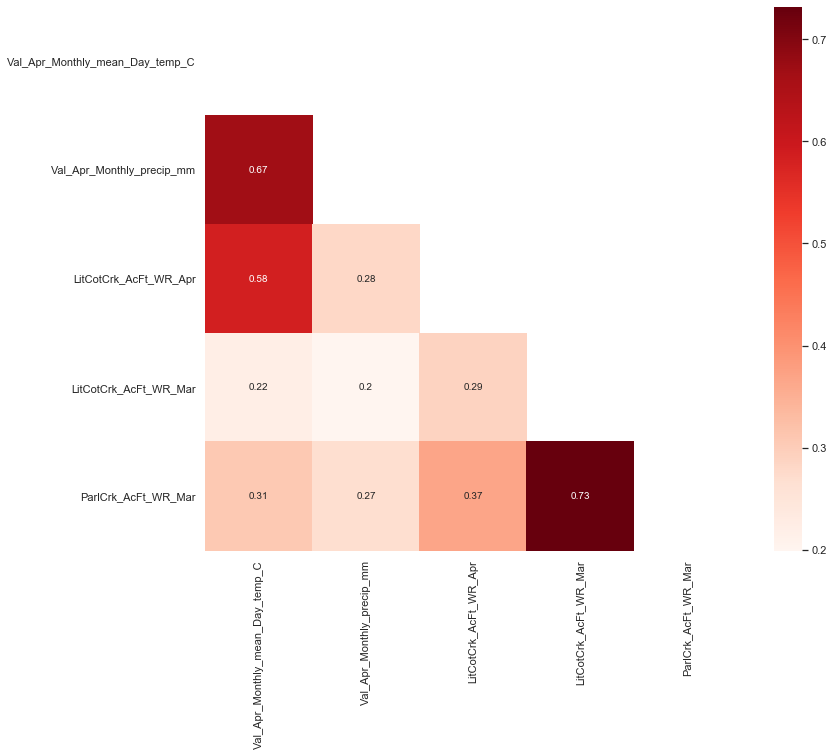

C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Ryan\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


The outdoor Demand prediction RMSE is  10.091412513931513
The outdoor Demand prediction R2 is  0.18769874176088674
The Total Demand prediction RMSE is  13.268172887056117
The Total Demand prediction R2 is  0.329035408009384
The Total Demand prediction MAE is  13.216378923217661
The Total Demand prediction MAPE is  0.09463600480450647 %
The final set of features for Apr are ['Val_Apr_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_precip_mm', 'LitCotCrk_AcFt_WR_Apr', 'LitCotCrk_AcFt_WR_Mar']
The coefficients for each feature are [ 5.63580354 -0.30790015  0.0073984  -0.01200673]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
285         False         False           0.25                 0.8  10.091413
The model is automatically selecting features and calibrating the  May outdoor demand model.
The automated algorithm optimizes the respective model by looping over input parameters within
the t

KeyboardInterrupt: 

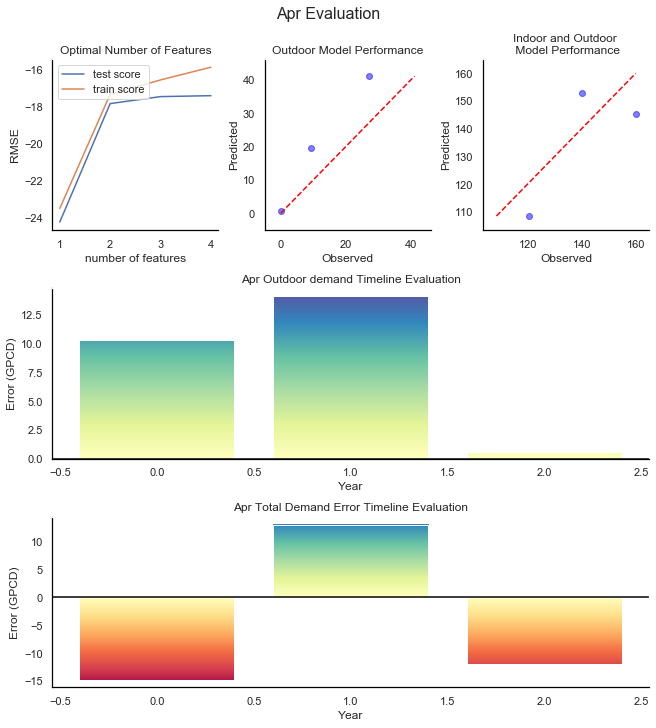

In [9]:
#Create the list of parameters to search through to optimize model performance
p_space = {
    'snowfeatures': [True, False],
    'conservation': [True, False],
    'cor_threshold': np.arange(0,0.7, 0.05),
    'colinearity_thresh': [0.65, 0.7, 0.75, 0.80, 0.85, 0.90]
}

Outdoor_Months=['Apr', 'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
IndoorMonths = ['Jan', 'Feb', 'Mar', 'Nov', 'Dec']



slc_val=copy.deepcopy(slc_test)
# calibrate and predict with the outdoor model
pbar = ProgressBar()
for i in pbar(Outdoor_Months):
    print('The model is automatically selecting features and calibrating the ', i, 'outdoor demand model.' )
    #put the month, use conservation_goal (-1: no, -2: yes) correlation threshold,
    #colineariy threshold, CV, aplpha, model type, tuning method
    #put in the params, month, scoring method (R2, or RMSE for now)
    PerfDF, cv_results, cor, X_test_RFE, coef = Demand_Optimization(p_space, i, 'RMSE')
    
    colrem = slc_test[i].columns
    slc_val[i] = slc_val[i].reset_index(drop=True)
    slc_val[i] = pd.concat([slc_val[i], PerfDF], axis=1, join="inner")
    slc_val[i] = slc_val[i].set_index('Date')
    slc_val[i] = slc_val[i].drop(columns=colrem)

#Calibrate and predict with the indoor model
for i in IndoorMonths:
    slc_val = Indoor_Demand_Model(slc_val, i)


#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 
                           'MLR_Seasonal_term_pred_gpcd','SLC-WDM ','blue', 'orange')

In [ ]:
#save predictions
#np.save('ModelOutput/Slc_Pred_Low_Ave_High_WY.npy', slc_val)


In [15]:
slc_val = np.load('ModelOutput/Slc_Pred_Low_Ave_High_WY.npy', allow_pickle =True).item()


yes
Total R2 is  0.9766188032681973
Total MAE is  16.64387014491631
Total RMSE is  19.547113475292928
Total MAPE is  8.419832806068381


<ipython-input-8-c03814f5f804>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
<ipython-input-8-c03814f5f804>:95: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


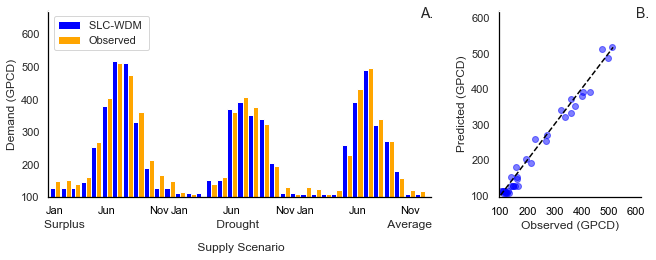

In [16]:
#Put it all together and display the results, need to adjust the term forecast depending on training data
import matplotlib.dates as mdates

df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'MLR_Seasonal_term_pred_gpcd','SLC-WDM ',
                           'blue', 'orange')

In [20]:
slc_train['Apr'].columns

Index(['Val_Apr_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_precip_mm',
       'CityCrk_AcFt_WR_Apr', 'ParlCrk_AcFt_WR_Apr', 'BigCotCrk_AcFt_WR_Apr',
       'LitCotCrk_AcFt_WR_Apr', 'ParlCrk_AcFt_WR_Mar', 'BigCotCrk_AcFt_WR_Mar',
       'LitCotCrk_AcFt_WR_Mar', 'Housing', 'HousingDensity', 'Nov_snow_in',
       'Dec_snow_in', 'Jan_snow_in', 'Feb_snow_in', 'Mar_snow_in',
       'Apr_snow_in', 'Total_snow_in', 'Snow_shortage', 'Target_gpcd',
       'cons_goal'],
      dtype='object')

In [24]:
from pandas.tseries.offsets import MonthEnd
cols = ['y_test_tot', 'y_pred_tot']
monthorder = ['Jan', 'Feb' , 'Mar', 'Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Pred_Obs = Pred_Obs[cols]

#input population into DF to calculate total water demands.
Population = []
UR_gpcd = []

slc_pred = copy.deepcopy(slcallData)

for i in monthorder:
    slc_train[i] = copy.deepcopy(slcallData[i].loc[:2010])
    slc_pred[i] = slc_pred[i].loc[2015:]
    slc_pred[i]['UR_gpcd'] = np.mean(slc_train[i]['Obs_gpcd'])
    Population.append(np.round(slc_pred[i]['Population'],0))
    
UR=pd.DataFrame()
for i in slc_pred:
    slc_pred[i]= pd.DataFrame(slc_pred[i]['UR_gpcd'])
    slc_pred[i]=slc_pred[i].reset_index()
    slc_pred[i]['M'] = datetime.datetime.strptime(i, "%b").month
    slc_pred[i]['D'] = 1
    slc_pred[i]['Date'] = pd.to_datetime(slc_pred[i].Year*10000+slc_pred[i].M*100+slc_pred[i].D,format='%Y%m%d')+MonthEnd(1)
    slc_pred[i].index = slc_pred[i].Date
    slc_pred[i]=slc_pred[i].drop(columns = ['M', 'D', 'Date', 'Year'])
    UR = UR.append(slc_pred[i])

UR=UR.sort_index()
Population = np.sort(np.array(Population).reshape(36,))

#place in to prediction df
Pred_Obs['Population'] = Population
Pred_Obs['UR_gpcd'] = UR['UR_gpcd']



#Now we can form some acre-feet predictions.
gpcd=['y_test_tot','y_pred_tot','UR_gpcd']
for i in gpcd:
    Pred_Obs[i+str('_AF')] = Pred_Obs[i]*Pred_Obs['Population']*9.33454e-5

    
remcol=['y_test_tot','y_pred_tot','UR_gpcd', 'Population']
Ann_Eval = Pred_Obs.drop(columns = remcol).copy()
Ann_Eval = Ann_Eval.resample('Y').sum()



pdict is not used
Total R2 is  0.9765992771958528
Total MAE is  537.3515654137589
Total RMSE is  630.708116168728
Total MAPE is  8.419832806068387


<ipython-input-8-c03814f5f804>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
<ipython-input-8-c03814f5f804>:95: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


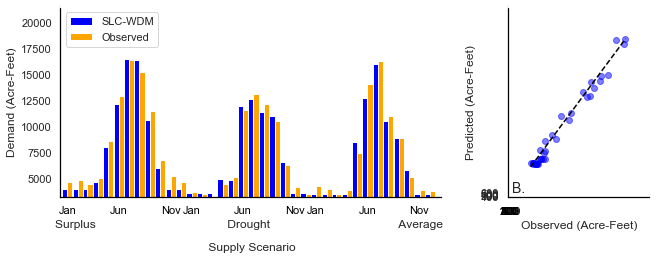

In [25]:
Pred_AF = Demand_Forecast(slc_val, False, Pred_Obs, 
            'y_pred_tot_AF', 'y_test_tot_AF', 'Acre-Feet', 'MLR_Seasonal_term_pred_AF', 'SLC-WDM', 'blue', 'orange')

In [ ]:
#Your Done!

pdict is not used
Total R2 is  0.6283371213177069
Total MAE is  63.03597863247863
Total RMSE is  77.93344228795345
Total MAPE is  30.78863740465362


<ipython-input-8-c03814f5f804>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
<ipython-input-8-c03814f5f804>:95: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


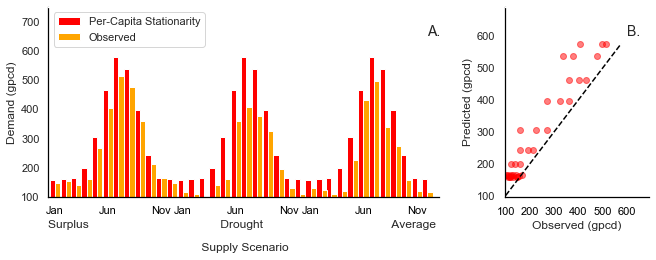

In [26]:
Pred_UR_GPCD = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd',
                'y_test_tot', 'gpcd', 'Stationary_Demand_Forecast_gpcd', 'Per-Capita Stationarity','red', 'orange')

In [27]:
Pred_UR_GPCD['StationaryError'] = ((Pred_UR_GPCD['UR_gpcd']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['SLCWDMError'] = ((Pred_UR_GPCD['y_pred_tot']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['StationaryErrorAF'] = Pred_UR_GPCD['UR_gpcd_AF']-Pred_UR_GPCD['y_test_tot_AF']
Pred_UR_GPCD['SLCWDMErrorAF'] = Pred_UR_GPCD['y_pred_tot_AF']-Pred_UR_GPCD['y_test_tot_AF']
Evalcol = ['y_test_tot_AF', 'y_pred_tot_AF', 'StationaryError','SLCWDMError', 'StationaryErrorAF', 'SLCWDMErrorAF']
Eval = Pred_UR_GPCD[Evalcol]

Annual = Eval.resample('Y').sum()
Annual['S_Perror'] = Annual['StationaryErrorAF']/Annual['y_test_tot_AF']*100
Annual['SLCWDM_Perror'] = Annual['SLCWDMErrorAF']/Annual['y_test_tot_AF']*100
Annual

,y_test_tot_AF,y_pred_tot_AF,StationaryError,SLCWDMError,StationaryErrorAF,SLCWDMErrorAF,S_Perror,SLCWDM_Perror
Date,,,,,,,,
2015-12-31,100550.276769,94468.369531,139.858017,-112.889766,12207.162705,-6081.907237,12.140357,-6.048623
2016-12-31,81646.774954,81484.779554,512.522236,4.603096,32430.298904,-161.995400,39.720245,-0.198410
2017-12-31,86505.457871,83638.300459,455.384862,-48.858969,28891.579705,-2867.157412,33.398563,-3.314424


In [ ]:
#Get monthly stats for UR
URcol = ['y_test_tot', 'UR_gpcd']
Pred_UR_GPCD = Pred_UR_GPCD[URcol]
Pred_UR_GPCD['Month'] = Pred_UR_GPCD.index.month
UR = {}

Irrmon = np.arange(4,11,1)
month = ['Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct']
for i in Irrmon:
    UR[i]=Pred_UR_GPCD.loc[Pred_UR_GPCD['Month']==i]
    
for i in UR:
    
    print( calendar.month_name[i], 'Unit Rate Performance Metrics.')
    T_r2 = sklearn.metrics.r2_score(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_rmse= sklearn.metrics.mean_squared_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])*100
        
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%') 
    


In [ ]:
Pred_UR_AF = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd_AF', 
                             'y_test_tot_AF', 'Acre-Feet', 'Seasonal_term_pred_UR_AF', 'Per-Capita Stationarity', 'red', 'orange')

In [ ]:
'''I am putting a hard code on the limits here to make both figure have same color scale'''

plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars, ymin, ymax):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
 #   ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral_r')
    ax.axis([xmin, xmax, ymin, ymax])


In [ ]:
#Reduce width to increase space between bars
width = .9
widthM = 1
titlesize = 14

Ann_Eval['Supply'] = ['Surplus', 'Drought', 'Average']
Ann_Eval.index = Ann_Eval['Supply']

DayDF = Ann_Eval

fig, ax = plt.subplots(3,1, constrained_layout=True)
fig.set_size_inches(9,11)
DayDF['Error_SLC_WDM'] = DayDF.y_pred_tot_AF-DayDF.y_test_tot_AF
DayDF['Error_UR'] = DayDF.UR_gpcd_AF-DayDF.y_test_tot_AF


#Annual Figure

ax[0].bar(DayDF.Supply, DayDF.UR_gpcd_AF, width=width, 
    color='red', label='Base')
ax[0].bar(DayDF.Supply, DayDF.y_pred_tot_AF, width=width, 
    color='orange', label='MLR')
ax[0].bar(DayDF.Supply, DayDF.y_test_tot_AF, width=width, 
    color='blue', label='Observed')
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Acre-Feet')
ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')


Error_UR = ax[1].bar(DayDF.index, DayDF.Error_UR, width=width, 
    color='red', label='Base')
ax[1].set_ylabel('Acre-Feet')
ax[1].set_title('Base: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_UR, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')



Error_SLC_WDM = ax[2].bar(DayDF.Supply, DayDF.Error_SLC_WDM, width=width, 
    color='red', label='Unit-Rate')
ax[2].set_ylabel('Acre-Feet')
ax[2].set_title('MLR: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_SLC_WDM, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')

#fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/SLC_WDMvsUR.pdf')

In [ ]:
#Make similar figure to one above, but include RFR and MLP.
#Make bars side by side rather than stacked
Preds = ['y_test_tot_AF' ,'y_pred_tot_AF', 'UR_gpcd_AF' ]
Err = ['Error_SLC_WDM', 'Error_UR' ]
labels = ['Observed','SLC-WDM' , 'Stationary']
label2 = ['SLC-WDM' ,  'Stationary']


Preds = DayDF[Preds].copy()
Preds.columns = labels
Err = DayDF[Err].copy()
Err.columns =label2
ErrPerc = Err.copy()

ErrPerc['Stationary'] = round(((Preds['Stationary']-Preds['Observed'])/Preds['Observed'])*100,1)
ErrPerc['SLC-WDM'] = round(((Preds['SLC-WDM']-Preds['Observed'])/Preds['Observed'])*100,1)


In [ ]:
#Reduce width to increase space between bars
width = .8
widthM = 1
titlesize = 14

colorA  = ['orange', 'red', 'blue' ]
colorB  = ['red','blue' ]

colorder = ['Observed', 'Stationary', 'SLC-WDM']
colorder2 = [ 'Stationary', 'SLC-WDM']

Preds = Preds[colorder]
Preds=Preds.rename(columns={"Stationary": "Per-Capita Stationarity"})

Err = Err[colorder2]
Err=Err.rename(columns={"Stationary": "Per-Capita Stationarity"})


fig, ax = plt.subplots(2,1, constrained_layout=True)
fig.set_size_inches(9,9)

#Annual Figure

Preds.plot(ax=ax[0], kind='bar', grid=True, width=width, color = colorA)
ax[0].legend(labels)
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Seasonal Forecast (Ac-Ft)', size = 14)
ax[0].set_ylim(0,np.max(Preds['Per-Capita Stationarity'])+50000)
#ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].tick_params(labelrotation=0, labelsize = 13)
ax[0].xaxis.label.set_visible(False)
ax[0].text(2.3, 150000, "A.", size = 16)


Err.plot(ax=ax[1], kind='bar', grid=True, width =width, color=colorB, legend=False)
ax[1].set_ylabel('Seasonal Forecast Error (Ac-Ft)', size = 14)
#ax[1].set_title('Error', size = titlesize)
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].tick_params(labelrotation=0, labelsize = 13)
ax[1].axhline(y=0, color='black', linestyle='-')
#ax[1].xaxis.label.set_visible(False)
ax[1].set_xlabel('Supply Scenario', size = 14)
ax[1].text(2.3,32000, 'B.', size = 16)

ax2 = ax[1].twinx()
ax2.spines['right'].set_position(('axes', 1))
ax2.set_ylim(-16.8,42)
ax2.set_ylabel('Seasonal Forecast Error (%)', size = 14)
ax2.plot(ax=ax2)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.spines['right'].set_color('black')



rects = ax[1].patches

# Make some labels.
labels = list(ErrPerc['Stationary'])+list(ErrPerc['SLC-WDM'])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0:
       # [str(i)+ '%' for i in labels]
        ax[1].text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', size = 12)
    else:
        ax[1].text(rect.get_x() + rect.get_width() / 2, height - 2000, str(label)+'%',
            ha='center', va='bottom', size = 12)




#fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/UR_SLCWDM_Demand_compare.pdf')

In [ ]:

#Make a function to put all of the predictions together
def Demand_Forecastgpcd_AF(gpcd, pdict, df, pred1, test1,pred2, test2, units1, units2, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in gpcd:
            FinalDF=FinalDF.append(gpcd[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
   # months = np.arange(1,6,1)
   # Low = list()
    #Ave=list()
    #High = list()
    #for i in months:
    #    Low.append('Low'+str(i))
    #    Ave.append('Ave'+str(i))
    #    High.append('High'+str(i))
        
    #Low.append('Drought')
    #Ave.append('Average')
    #High.append('Surplus')
    
    #months2 = np.arange(7,13,1)
    #for i in months2:
    #    Low.append('Low'+str(i))
    #    Ave.append('Ave'+str(i))
    #    High.append('High'+str(i))
    
   # Conditions = High+Low+Ave

    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
    #FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot1 = FinalDF[[pred1, test1]].min().min()
    plotmax_tot1 = FinalDF[[pred1, test1]].max().max()
    
    plotmin_tot2 = FinalDF[[pred2, test2]].min().min()
    plotmax_tot2 = FinalDF[[pred2, test2]].max().max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')

    fig, ax = plt.subplots(2,6, constrained_layout=True)
    fig.set_size_inches(10,5)

    gs1 = ax[0,0].get_gridspec()
    # remove the underlying axes
    ax[0,0].remove()
    ax[0,1].remove()
    ax[0,2].remove()
    axbig = fig.add_subplot(gs1[0,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.plot(FinalDF[pred1], color='orange', label= model)
    #axbig.plot(FinalDF[test1],color='blue', label='Observed')
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred1], color='orange', label= 'SLC-WDM',width = 15,  align="center")
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test1], color='blue', label= 'Observed',width = 15,  align="center")
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot1-.9,plotmax_tot1*1.4)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units1+')')
    axbig.legend(loc = 'upper left', facecolor = 'white')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
   
    
   # xticks = axbig.xaxis.get_major_ticks()
    #for i,tick in enumerate(xticks):
     #   if i%12 != 5:
      #      tick.label1.set_visible(False)

    ax[0,3].remove()
    ax[0,4].remove()
    ax[0,5].remove()


    axbig2 = fig.add_subplot(gs1[0:,3:])
    axbig2.scatter(FinalDF[test1], FinalDF[pred1],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units1+')' )
    axbig2.set_xlabel('Observed (' + units1+')')
    axbig2.set_ylim(plotmin_tot1*.95,plotmax_tot1*1.2)
    axbig2.set_xlim(plotmin_tot1*.95,plotmax_tot1*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot1,plotmax_tot1],[plotmin_tot1,plotmax_tot1], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.text(550,600, 'C.', size = 16)
    #ax[2].set_aspect('equal', adjustable='box')
    
    
    
    
    gs2 = ax[1,0].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()
    ax[1,3].remove()
    ax[1,4].remove()
    ax[1,5].remove()
    axbig = fig.add_subplot(gs2[1,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.plot(FinalDF[pred2], color='orange', label= 'Predicted')
    axbig.bar(FinalDF.index-np.timedelta64(7, 'D'), FinalDF[pred2], color='orange', label= 'SLC-WDM',width = 15,  align="center")
    #axbig.plot(FinalDF[test2],color='blue', label='Observed')
    axbig.bar(FinalDF.index+np.timedelta64(8, 'D'), FinalDF[test2], color='blue', label= 'Observed',width = 15,  align="center")    
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot2-.9,plotmax_tot2*1.2)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Demand ('+ units2+')')
    #axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='red')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    axbig.annotate('B.', (FinalDF.index[-1], 17000), size = 14)
    xticks = axbig.xaxis.get_major_ticks()
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
    
    
    #axbig.text(35,17000, 'B.', size = 16)
    #axbig.get_legend().remove()
    
    #xticks = axbig.xaxis.get_major_ticks()
    #for i,tick in enumerate(xticks):
     #   if i%12 != 5:
      #      tick.label1.set_visible(False)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLR_Seasonal_gpcd_AFbar.pdf')

In [ ]:
Demand_Forecastgpcd_AF(slc_val, False, Pred_Obs, 
            'y_pred_tot', 'y_test_tot','y_pred_tot_AF', 'y_test_tot_AF', 'gpcd', 'Acre-Feet', 'MLR_Performance', 'SLC-WDM ')

In [ ]:

#Make a function to put all of the predictions together
def MultiModelDemand_Forecast(prediction_dictionary, Error, pdict, df, units, plotname):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('pdict is not used')
 
    #adjust date range to improve figure
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2017,12,1), freq='MS')
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    
    #Error or no error
    if Error ==False:
        Observed = FinalDF['Observed']
        SLCWDM = FinalDF['SLCWDM']
        Stationary = FinalDF['Per-Capita Stationarity']
    if Error == True:
        SLCWDM = FinalDF['SLCWDM_Error']
        Stationary = FinalDF['Stationary_Error']
        
        SLCWDM_MAPE = FinalDF['SLCWDM_Error_MAPE']
        Stationary_MAPE = FinalDF['Stationary_Error_MAPE']

    
    plotmin_tot = SLCWDM.min()-5
    plotmax_tot = Stationary.max()
    
    plotmin_Perc = SLCWDM_MAPE.min()-5
    plotmax_Perc = Stationary_MAPE.max()
    
    Xplotmin = FinalDF.index[0]-np.timedelta64(20, 'D')
    Xplotmax = FinalDF.index[-1]+np.timedelta64(33, 'D')
    
    plt.rc_context({ 'xtick.color':'black'})
    fig, ax = plt.subplots(2,3, constrained_layout=True)
    fig.set_size_inches(12,9)

    gs = ax[0,2].get_gridspec()
    # remove the underlying axes
    ax[0,0].remove()
    ax[0,1].remove()
    ax[0,2].remove()
    axbig = fig.add_subplot(gs[0,:3])
    axbig.set_facecolor("white")
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.bar(FinalDF.index,FinalDF['Observed'], color='blue', width= 15, label='Observed', zorder=1)
    #if Error ==False:
     #   axbig.plot(FinalDF.index,Observed, color='blue', label='Observed', zorder=1)
    axbig.bar(FinalDF.index-np.timedelta64(11, 'D'), SLCWDM, color='blue', label= 'SLC-WDM',width = 7, zorder=3, align="center")
    axbig.bar(FinalDF.index+np.timedelta64(10, 'D'),Stationary, color='red', label= 'Per-Capita Stationarity', width = 7, zorder=1,align="center")
    axbig.axhline( y = 0, color= 'black')
    
    #axbig.set_xlabel('Surplus                                                                  Drought                                                                 Average \n \n Supply Scenario', size = 16)
    axbig.set_ylim(plotmin_tot*1.2,plotmax_tot*1.2)
    axbig.set_xlim(Xplotmin, Xplotmax)
    axbig.set_ylabel('Prediction Error ('+ units+')', size = 16)
    axbig.legend(loc = 'upper left', facecolor = 'white', fontsize=13)
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.tick_params(axis='both', which='both', length=5, color='black')
    axbig.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig.tick_params(axis = 'both', labelsize = 14)
    axbig.annotate('A.', (FinalDF.index[-1], 6500), size = 16)


    

    #axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    #make a list of desired months
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)
            
    #gs2 = ax[1,2].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()
    axbig2 = fig.add_subplot(gs[1,:3])
    axbig2.set_facecolor("white")
    #axbig.set_title('Total demand Timeline Evaluation')
    #axbig.bar(FinalDF.index,FinalDF['Observed'], color='blue', width= 15, label='Observed', zorder=1)
    #if Error ==False:
     #   axbig.plot(FinalDF.index,Observed, color='blue', label='Observed', zorder=1)
    axbig2.bar(FinalDF.index-np.timedelta64(11, 'D'), SLCWDM_MAPE, color='blue', label= 'SLC-WDM',width = 7, zorder=3, align="center")
    axbig2.bar(FinalDF.index+np.timedelta64(10, 'D'),Stationary_MAPE, color='red', label= 'Per-Capita Stationarity', width = 7, zorder=1,align="center")
    axbig2.axhline( y = 0, color= 'black')
    
    axbig2.set_xlabel('Surplus                                                Drought                                               Average \n \n Supply Scenario', size = 16)
    axbig2.set_ylim(plotmin_Perc*.9,plotmax_Perc*1.2)
    axbig2.set_xlim(Xplotmin, Xplotmax)
    axbig2.set_ylabel('Prediction Error (%)', size = 16)
    #axbig2.legend(loc = 'upper left')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.tick_params(axis='both', which='both', length=5, color='black')
    axbig2.xaxis.set_major_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    axbig2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    axbig2.tick_params(axis = 'both', labelsize = 14)
    axbig2.annotate('B.', (FinalDF.index[-1], 100), size = 16)


    

    #axbig.annotate('A.', (FinalDF.index[-1], 600), size = 14)
    #make a list of desired months
    months = [0,5,10,12,17,22,24,29,34]
    
    xticks = axbig2.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        #if i%5.5 != 0:
        if i not in months:
            tick.label1.set_visible(False)

            
    
   

   # fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')

    
 
    return FinalDF

In [ ]:

Model_Comp = copy.deepcopy(slc_pred)


#make unique labels for each model
for i in slc_val:
    slc_val[i]['SLCWDM'] = slc_val[i]['y_pred_tot']
    slc_val[i]['Observed'] = slc_val[i]['y_test_tot']
    slc_pred[i]['Per-Capita Stationarity'] = slc_pred[i]['UR_gpcd']
    
    
    #align the index on them all, slc-pred already has the updated dates
    slc_val[i].index = slc_pred[i].index
    
    #put all into their own dictionaries
    Model_Comp[i]['Observed'] = slc_val[i]['Observed']*350000*3.069e-6*30
    Model_Comp[i]['SLCWDM'] = slc_val[i]['SLCWDM']*350000*3.069e-6*30
    Model_Comp[i]['Per-Capita Stationarity'] = slc_pred[i]['Per-Capita Stationarity']*350000*3.069e-6*30
    
    #Create ML error values
    Model_Comp[i]['SLCWDM_Error'] = Model_Comp[i]['SLCWDM']-Model_Comp[i]['Observed']
    Model_Comp[i]['Stationary_Error'] =  Model_Comp[i]['Per-Capita Stationarity']-Model_Comp[i]['Observed']
    
    Model_Comp[i]['SLCWDM_Error_MAPE'] = (Model_Comp[i]['SLCWDM_Error']/Model_Comp[i]['Observed'])*100
    Model_Comp[i]['Stationary_Error_MAPE'] =  (Model_Comp[i]['Stationary_Error']/Model_Comp[i]['Observed'])*100
    
    
    del Model_Comp[i]['UR_gpcd']




In [ ]:
Model_Comparision = MultiModelDemand_Forecast(Model_Comp, True, True, Pred_Obs,  'Ac-Ft', 'Model_Comparison')